### Import required packages and functions

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy.stats import skew, kurtosis
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import pandas_datareader.data as web
# import warnings
# warnings.filterwarnings("ignore")
from functions import delta_hedging, calendar_to_business_days, create_straddles, process_straddles, dp_hedging_collect_training_data, train_random_forest_model, apply_hedging_model, get_feature_importance, plot_feature_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

### Initialize important dates

In [2]:
start_date = '2007-01-01'
end_date = '2023-09-30'

training_start_date = '2007-01-01'
training_end_date = '2015-12-31'
test_start_date = '2016-01-01'
test_end_date = '2023-08-31'

### Fetch and Process S&P prices data

In [3]:
sp = yf.download('^SPX')

sp.index = pd.to_datetime(sp.index)

# Filter the DataFrame
filtered_sp = sp.loc[start_date:end_date]

# Remove the ticker level from the multi index
filtered_sp.columns = filtered_sp.columns.droplevel(1)
filtered_sp = pd.DataFrame(filtered_sp['Close'], index=filtered_sp.index)
filtered_sp.index = pd.to_datetime(filtered_sp.index).tz_localize(None)

[*********************100%***********************]  1 of 1 completed


### Fetch and Process Fama French Risk free rate data

In [4]:
# Fetch the Fama-French 3-factor data
ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)

# Convert period index to datetime
rf_data = ff_data[0]  # Extract the first dataframe (RF)
rf_data.index = rf_data.index.to_timestamp()  

# Select the RF column (risk-free rate)
risk_free_rate = pd.DataFrame(rf_data['RF'])

# Resample to daily frequency, forward-fill missing values (public holidays), and annualize the risk free rate
risk_free_rate = risk_free_rate.resample('D').ffill()
risk_free_rate = risk_free_rate * 12 / 100

C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\383639444.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)
C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\383639444.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)


### Reindex data to forward fill prices and risk free for public holidays

In [5]:
market_df = filtered_sp.merge(risk_free_rate, left_index=True, right_index=True)

# Create a new business day index
new_index = pd.bdate_range(start=start_date, end=end_date)

# Create a new DataFrame with the business day index
real_market_df = pd.DataFrame(index=new_index)

# Merge the existing market_df with the new DataFrame
real_market_df = real_market_df.merge(market_df, left_index=True, right_index=True, how='left')

# Forward fill the missing values
real_market_df.ffill(inplace=True)

# Rename the index to 'Date' if necessary
real_market_df.index.name = 'Date'

# Display the updated DataFrame
real_market_df

,Close,RF
Date,,
2007-01-01,NaN,NaN
2007-01-02,NaN,NaN
2007-01-03,1416.599976,0.0528
2007-01-04,1418.339966,0.0528
2007-01-05,1409.709961,0.0528
...,...,...
2023-09-25,4515.770020,0.0516
2023-09-26,4515.770020,0.0516
2023-09-27,4515.770020,0.0516


### Read Option data

In [6]:
# Read data from CSV
data = pd.read_csv('filtered_data_cleaned.csv')
data.set_index('Date', inplace=True)

### Define training and testing data

In [7]:
data_train = data[training_start_date:training_end_date]
option_df_train = data_train
data_train.index = pd.to_datetime(data_train.index)

data_test = data[test_start_date:test_end_date]
option_df_test = data_test
data_test.index = pd.to_datetime(data_test.index)

In [8]:
option_df_test

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,D to Expiration,Close,Moneyness
Date,,,,,,,,,,,,,,,,
2016-01-04,2016-01-15,C,1890.0,120.7,124.4,5,NaN,NaN,NaN,NaN,NaN,108992380,100,11,2012.660034,0.939056
2016-01-04,2016-01-15,C,1920.0,93.9,96.4,0,0.200716,0.924862,0.002120,47.22370,-180.0008,108992385,100,11,2012.660034,0.953961
2016-01-04,2016-01-15,C,1925.0,89.5,92.0,2,0.203888,0.909817,0.002394,54.18009,-208.5164,103574109,100,11,2012.660034,0.956446
2016-01-04,2016-01-15,C,1940.0,76.4,79.5,4,0.209880,0.859691,0.003188,74.26003,-291.0031,106241770,100,11,2012.660034,0.963899
2016-01-04,2016-01-15,C,1945.0,72.5,75.5,3,0.213153,0.838899,0.003442,81.42041,-323.1432,108992388,100,11,2012.660034,0.966383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,2023-09-29,P,4435.0,28.8,29.1,21,0.128259,-0.281094,0.002070,428.51640,-279.8151,154635934,100,29,4507.660156,0.983881
2023-08-31,2023-10-02,C,4515.0,65.4,65.9,0,0.111276,0.540238,0.002672,529.71470,-455.4730,156631215,100,32,4507.660156,1.001628
2023-08-31,2023-10-02,P,4515.0,53.5,53.9,12,0.112415,-0.459972,0.002645,529.75150,-232.4544,156631264,100,32,4507.660156,1.001628


### Compute MidPrice and convert calendar days to business days

In [9]:
# Get midprice for all data
data_train['Midprice'] = (data_train['best_bid'] + data_train['best_offer']) / 2
data_test['Midprice'] = (data_test['best_bid'] + data_test['best_offer']) / 2

# convert calendar to business days
option_df_train['Business_Days_to_Expiration'] = option_df_train.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)
option_df_test['Business_Days_to_Expiration'] = option_df_test.apply(lambda row: calendar_to_business_days(row.name, row['exdate'], row['D to Expiration']), axis=1)

C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\1883916920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Midprice'] = (data_train['best_bid'] + data_train['best_offer']) / 2
C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\1883916920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Midprice'] = (data_test['best_bid'] + data_test['best_offer']) / 2
C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\1883916920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a co

### Keep only options with 1 month or more to maturity

In [10]:
data_1m_train = data_train[data_train['Business_Days_to_Expiration'] >= 22]
data_1m_train.index = pd.to_datetime(data_1m_train.index)

data_1m_test = data_test[data_test['Business_Days_to_Expiration'] >= 22]
data_1m_test.index = pd.to_datetime(data_1m_test.index)

In [11]:
data_train

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,gamma,vega,theta,optionid,contract_size,D to Expiration,Close,Moneyness,Midprice,Business_Days_to_Expiration
Date,,,,,,,,,,,,,,,,,,
2007-01-03,2007-01-05,C,1410.0,8.60,9.60,510,0.114990,0.721566,0.027841,35.20272,-423.8510,32351194,100,2,1416.599976,0.995341,9.10,2
2007-01-03,2007-01-05,C,1425.0,0.85,1.15,452,0.088166,0.195586,0.029876,28.96400,-247.8629,32351201,100,2,1416.599976,1.005930,1.00,2
2007-01-03,2007-01-05,P,1410.0,1.65,2.15,398,0.109702,-0.269139,0.028697,34.61649,-325.9181,32351196,100,2,1416.599976,0.995341,1.90,2
2007-01-03,2007-01-05,P,1425.0,8.50,9.40,121,0.087117,-0.807273,0.029966,28.70537,-166.2188,32351190,100,2,1416.599976,1.005930,8.95,2
2007-01-03,2007-01-20,C,1410.0,16.20,17.80,853,0.096310,0.640082,0.013096,110.95200,-169.7719,32267913,100,17,1416.599976,0.995341,17.00,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,2016-02-05,P,1920.0,12.10,12.50,96,0.211088,-0.165773,0.001837,159.77450,-172.3587,109720047,100,36,2043.939941,0.939362,12.30,26
2015-12-31,2016-02-05,P,1925.0,12.70,13.10,49,0.209026,-0.173527,0.001910,164.52760,-175.7893,109720048,100,36,2043.939941,0.941808,12.90,26
2015-12-31,2016-02-05,P,1940.0,14.70,15.10,13,0.202866,-0.199030,0.002143,179.12060,-185.8717,109720051,100,36,2043.939941,0.949147,14.90,26


### Create Straddles for each dates

In [12]:
# Group the data by date, strike price, and expiration date
groups_train = data_1m_train.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])
groups_test = data_1m_test.groupby(['Date', 'strike_price', 'Business_Days_to_Expiration'])

straddles_df_train = create_straddles(groups_train)
straddles_df_test = create_straddles(groups_test)

### If the straddle starts later than 10th of the month, remove it to comply with the requirement that we choose a straddle at the "beginning" of the month

In [13]:
for dates in straddles_df_train.index:
    if dates.day > 10:
        straddles_df_train.drop(dates, inplace=True, errors='ignore')

for dates in straddles_df_test.index:
    if dates.day > 10:
        straddles_df_test.drop(dates, inplace=True, errors='ignore')

### For each month, choose only one straddle, the one with a moneyness closest to 1

In [14]:
first_straddles_monthly_train = process_straddles(straddles_df_train)
first_straddles_monthly_test = process_straddles(straddles_df_test)

c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_straddles_daily.drop(columns=['YearMonth', 'Moneyness_Diff'], inplace=True)
c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_straddles_daily.drop(columns=['YearMonth', 'Moneyness_Diff'], inplace=True)


In [15]:
# No transaction cost, training P&L
profit_no_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0)
profit_no_cost_train.set_index('Date', inplace=True)
profit_no_cost_train['Cumulative P&L'] = profit_no_cost_train['P&L'].cumsum()

c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp_prices = market_df['Close'].reindex(full_calendar).fillna(method='ffill')
c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_rates = market_df['RF'].reindex(full_calendar).fillna(method='ffill')


In [16]:
# Transaction cost, testing P&L
profit_cost_train = delta_hedging(first_straddles_monthly_train, option_df_train, real_market_df, transaction_cost=0.005)
profit_cost_train.set_index('Date', inplace=True)
profit_cost_train['Cumulative P&L'] = profit_cost_train['P&L'].cumsum()

c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp_prices = market_df['Close'].reindex(full_calendar).fillna(method='ffill')
c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_rates = market_df['RF'].reindex(full_calendar).fillna(method='ffill')


In [17]:
# No transaction cost, training P&L
profit_no_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0)
profit_no_cost_test.set_index('Date', inplace=True)
profit_no_cost_test['Cumulative P&L'] = profit_no_cost_test['P&L'].cumsum()
profit_no_cost_test

c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp_prices = market_df['Close'].reindex(full_calendar).fillna(method='ffill')
c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_rates = market_df['RF'].reindex(full_calendar).fillna(method='ffill')


,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.510379,109.949951,699.050987,-26.439572,-26.439572
2016-02-04,95.00,95.023291,107.189941,148.027371,-12.166650,-38.606222
2016-03-10,79.65,79.665468,90.729980,122.423439,-11.064513,-49.670735
2016-04-05,72.95,72.959369,1.609985,5090.734575,71.349384,21.678649
2016-05-04,66.45,66.457352,49.129883,300.241196,17.327469,39.006118
...,...,...,...,...,...,...
2023-04-06,173.75,174.563819,19.080078,24175.193697,155.483741,283.953363
2023-05-08,141.80,142.450138,158.859863,269.279072,-16.409725,267.543638
2023-06-08,108.60,109.156772,114.529785,28.869272,-5.373013,262.170625


In [18]:
# Transaction cost, testing P&L
profit_cost_test = delta_hedging(first_straddles_monthly_test, option_df_test, real_market_df, transaction_cost=0.005)
profit_cost_test.set_index('Date', inplace=True)
profit_cost_test['Cumulative P&L'] = profit_cost_test['P&L'].cumsum()
print(f"Tracking Error: {profit_cost_test['P&L'].std()}")
profit_cost_test

Tracking Error: 99.62706000252963


c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp_prices = market_df['Close'].reindex(full_calendar).fillna(method='ffill')
c:\Users\benj0\OneDrive - HEC Montréal\Desktop\Straddle_hedging_project\functions.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_rates = market_df['RF'].reindex(full_calendar).fillna(method='ffill')


,Initial Value,Final Cash Value,Payoff,Hedging Error,P&L,Cumulative P&L
Date,,,,,,
2016-01-06,83.50,83.468310,109.949951,701.277338,-26.481642,-26.481642
2016-02-04,95.00,94.899783,107.189941,151.048004,-12.290159,-38.771800
2016-03-10,79.65,79.422018,90.729980,127.870026,-11.307963,-50.079763
2016-04-05,72.95,72.583347,1.609985,5037.218067,70.973362,20.893598
2016-05-04,66.45,66.202729,49.129883,291.482079,17.072846,37.966445
...,...,...,...,...,...,...
2023-04-06,173.75,173.010255,19.080078,23694.499253,153.930177,249.283946
2023-05-08,141.80,141.013588,158.859863,318.489558,-17.846276,231.437670
2023-06-08,108.60,106.853616,114.529785,58.923575,-7.676169,223.761501


In [19]:
profit_cost_test['P&L'].median()

11.131225870380202

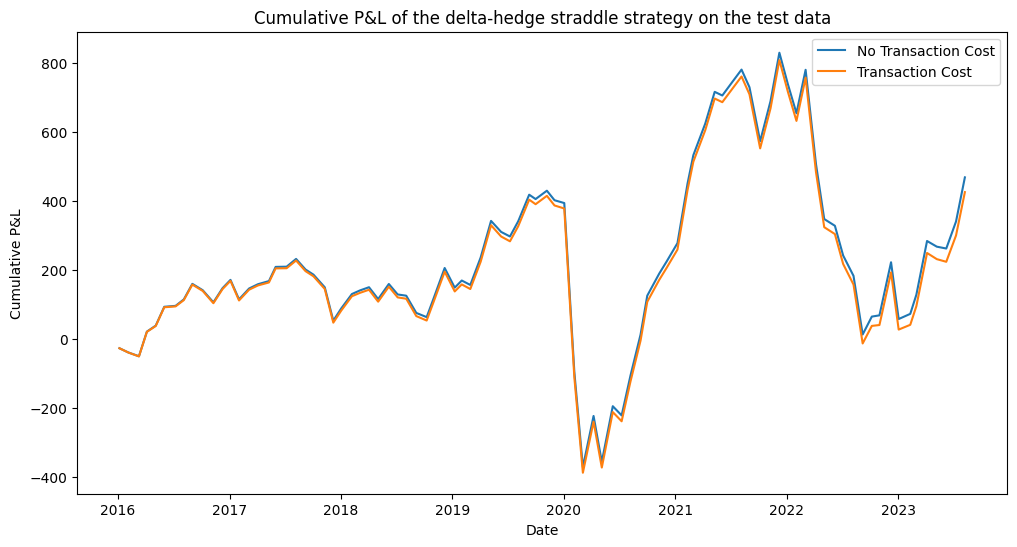

In [20]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_no_cost_test['Cumulative P&L'], label='No Transaction Cost')
plt.plot(profit_cost_test['Cumulative P&L'], label='Transaction Cost')
plt.title('Cumulative P&L of the delta-hedge straddle strategy on the test data')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

In [21]:
# Step 1: Train the random forest model
print("Training the random forest model...")
training_rf = dp_hedging_collect_training_data(straddles_df_train, data_train, real_market_df)
training_rf.set_index('Date', inplace=True)
print(f"Training data shape: {training_rf.shape}")

Training the random forest model...
Training data shape: (96035, 19)


In [22]:
rf_monthly = train_random_forest_model(training_rf)
print("Random forest model trained. Feature importances:")
print(rf_monthly.feature_importances_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random forest model trained. Feature importances:
[0.04212982 0.04772978 0.05256092 0.00585112 0.02658019 0.00986976
 0.12194422 0.00816172 0.04710962 0.05122519 0.16270158 0.01416342
 0.01338597 0.0210554  0.02861099 0.31590306 0.02177912 0.00923813]


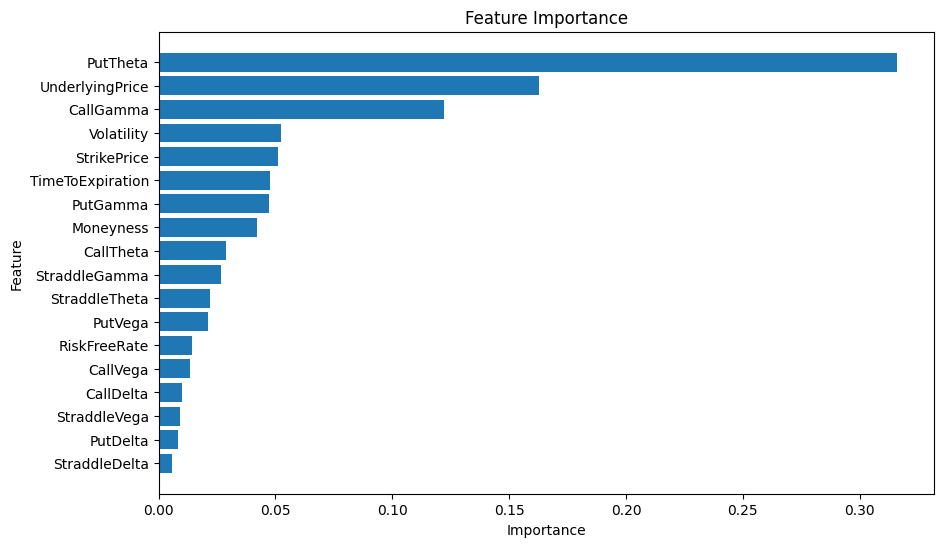

In [23]:
feature_names = training_rf.drop(columns=['Phi']).columns.tolist()
feature_importance_df = get_feature_importance(rf_monthly, feature_names)
# Plot feature importance
plot_feature_importance(feature_importance_df)

In [24]:
# Step 2: Apply the hedging model
print("Applying hedging model...")
try:
    results_df_monthly = apply_hedging_model(
        first_straddles_monthly_test, 
        data_test, 
        real_market_df, 
        rf_monthly, 
        transaction_cost=0.005
    )
except Exception as e:
    print(f"Error occurred while applying hedging model: {e}")

# Step 3: Check results
if results_df_monthly.empty:
    print("The results DataFrame is empty!")
else:
    print("Results DataFrame:")
    print(results_df_monthly.head())

    # Step 4: Add cumulative P&L
    results_df_monthly['Cumulative P&L'] = results_df_monthly['P&L'].cumsum()
    results_df_monthly.set_index('StartDate', inplace=True)
    print("Cumulative P&L added. Final DataFrame:")
    print(results_df_monthly.head())

    # Step 5: Print Tracking Error
    print(f"Tracking Error: {results_df_monthly['P&L'].std()}")

# Step 6: Display final DataFrame
results_df_monthly

Applying hedging model...
Results DataFrame:
   StartDate ExpirationDate  Initial Proceeds  Final Portfolio Value  \
0 2016-01-06     2016-02-05             83.50              84.159586   
1 2016-02-04     2016-03-11             95.00              93.596157   
2 2016-03-10     2016-04-15             79.65              78.559635   
3 2016-04-05     2016-05-13             72.95              72.921346   
4 2016-05-04     2016-06-03             66.45              65.818898   

   Straddle Payoff  Hedging Error        P&L  Total Transaction Costs  
0       109.949951     665.142914 -25.790365                 0.629789  
1       107.189941     184.790976 -13.593784                 0.452264  
2        90.729980     148.117298 -12.170345                 0.527593  
3         1.609985    5085.310188  71.311361                 0.233803  
4        49.129883     278.523233  16.689015                 0.249170  
Cumulative P&L added. Final DataFrame:
           ExpirationDate  Initial Proceeds  Final 

,ExpirationDate,Initial Proceeds,Final Portfolio Value,Straddle Payoff,Hedging Error,P&L,Total Transaction Costs,Cumulative P&L
StartDate,,,,,,,,
2016-01-06,2016-02-05,83.50,84.159586,109.949951,665.142914,-25.790365,0.629789,-25.790365
2016-02-04,2016-03-11,95.00,93.596157,107.189941,184.790976,-13.593784,0.452264,-39.384149
2016-03-10,2016-04-15,79.65,78.559635,90.729980,148.117298,-12.170345,0.527593,-51.554494
2016-04-05,2016-05-13,72.95,72.921346,1.609985,5085.310188,71.311361,0.233803,19.756867
2016-05-04,2016-06-03,66.45,65.818898,49.129883,278.523233,16.689015,0.249170,36.445882
...,...,...,...,...,...,...,...,...
2023-04-06,2023-05-12,173.75,174.167533,19.080078,24052.118810,155.087455,0.353732,223.593056
2023-05-08,2023-06-09,141.80,140.368891,158.859863,341.916068,-18.490973,0.558065,205.102083
2023-06-08,2023-07-10,108.60,107.440158,114.529785,50.262808,-7.089627,0.728516,198.012456


In [25]:
results_df_monthly['P&L'].median()

11.530056920204586

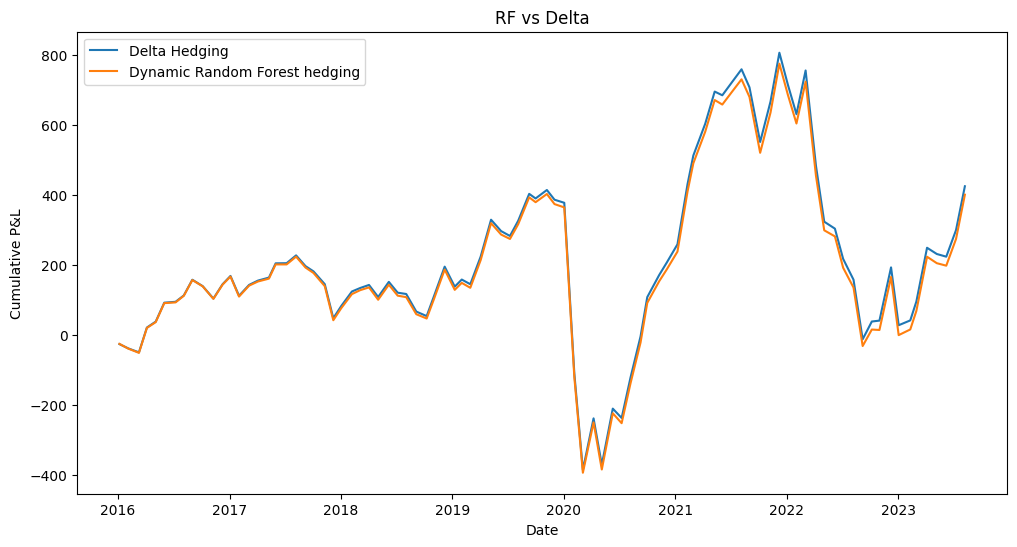

In [26]:
# Plot the cumulative P&L of the test data
plt.figure(figsize=(12, 6))
plt.plot(profit_cost_test['Cumulative P&L'], label='Delta Hedging')
plt.plot(results_df_monthly['Cumulative P&L'], label='Dynamic Random Forest hedging')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.show()

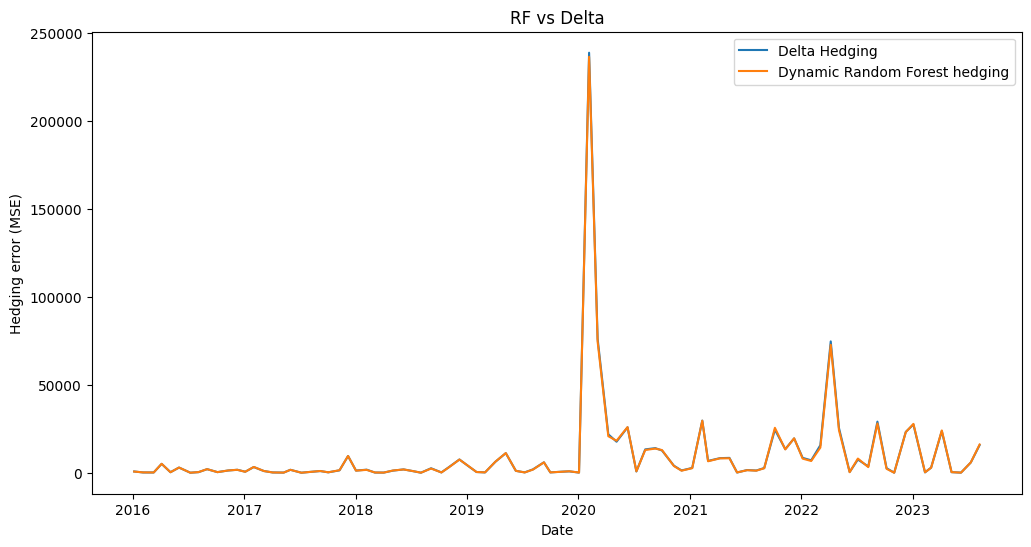

In [35]:
# Plot the hedging errors
plt.figure(figsize=(12, 6))
plt.plot(profit_cost_test['Hedging Error'], label='Delta Hedging')
plt.plot(results_df_monthly['Hedging Error'], label='Dynamic Random Forest hedging')
plt.title('RF vs Delta')
plt.xlabel('Date')
plt.ylabel('Hedging error (MSE)')
plt.legend()
plt.show()


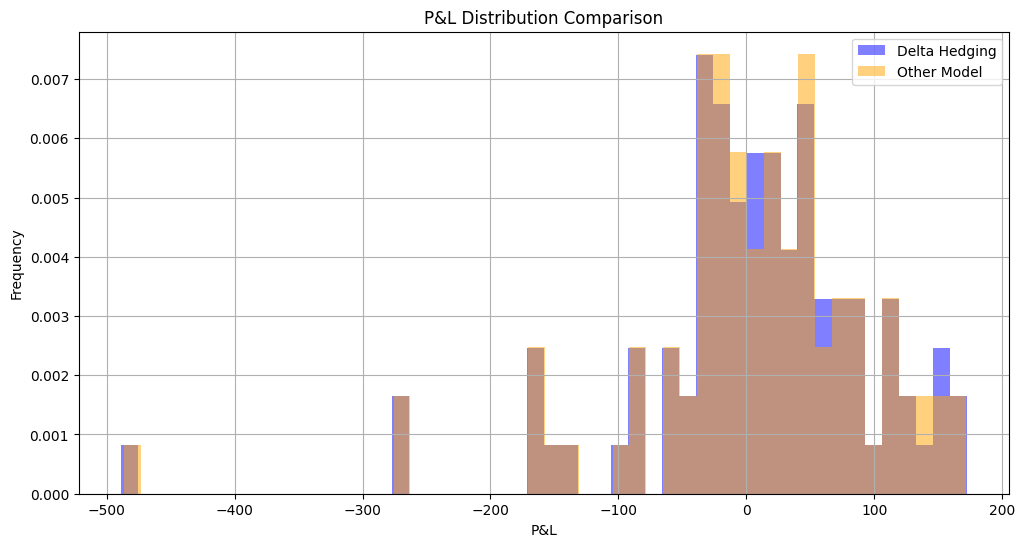

In [29]:
# Plot histograms for P&L distributions
plt.figure(figsize=(12, 6))

# Histogram for delta hedging model
plt.hist(profit_cost_test['P&L'], bins=50, alpha=0.5, label='Delta Hedging', color='blue', density=True)

# Histogram for the other model
plt.hist(results_df_monthly['P&L'], bins=50, alpha=0.5, label='Other Model', color='orange', density=True)

# Add titles and labels
plt.title('P&L Distribution Comparison')
plt.xlabel('P&L')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\2212857940.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(profit_cost_test['P&L'], label='Delta Hedging', color='blue', shade=True)
C:\Users\benj0\AppData\Local\Temp\ipykernel_62180\2212857940.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(results_df_monthly['P&L'], label='Other Model', color='orange', shade=True)


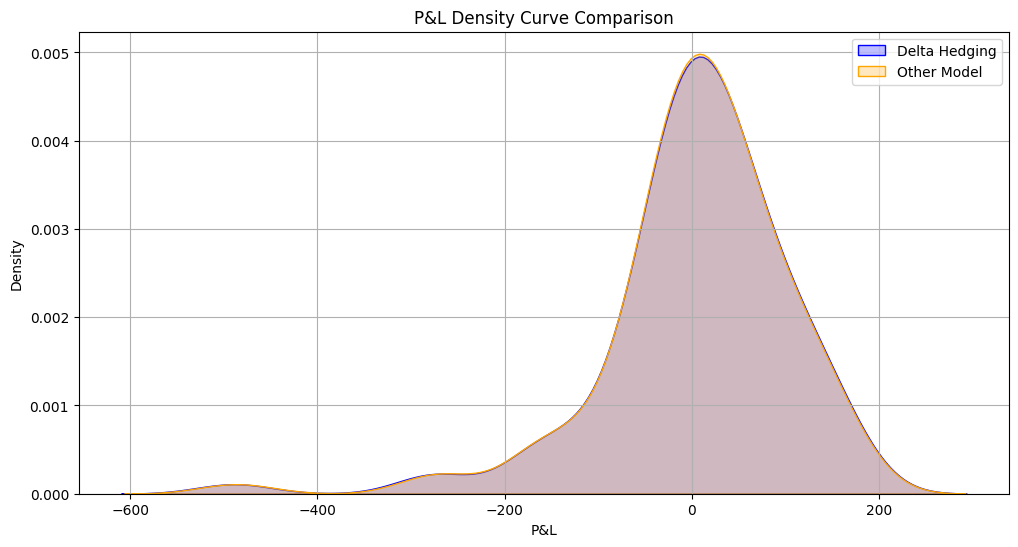

In [30]:
# Plot KDE for P&L distributions
plt.figure(figsize=(12, 6))

# KDE for delta hedging model
sns.kdeplot(profit_cost_test['P&L'], label='Delta Hedging', color='blue', shade=True)

# KDE for the other model
sns.kdeplot(results_df_monthly['P&L'], label='Other Model', color='orange', shade=True)

# Add titles and labels
plt.title('P&L Density Curve Comparison')
plt.xlabel('P&L')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [34]:
# Calculate statistical measures for delta hedging model
mean_delta_hedging = profit_cost_test['P&L'].mean()
median_delta_hedging = profit_cost_test['P&L'].median()
skewness_delta_hedging = skew(profit_cost_test['P&L'])
kurtosis_delta_hedging = kurtosis(profit_cost_test['P&L'])

# Calculate statistical measures for the other model
mean_other_model = results_df_monthly['P&L'].mean()
median_other_model = results_df_monthly['P&L'].median()
skewness_other_model = skew(results_df_monthly['P&L'])
kurtosis_other_model = kurtosis(results_df_monthly['P&L'])

# Print the results
print("Delta Hedging Model:")
print(f"Mean: {mean_delta_hedging}")
print(f"Median: {median_delta_hedging}")
print(f"Skewness: {skewness_delta_hedging}")
print(f"Kurtosis: {kurtosis_delta_hedging}")

print("\nOther Model:")
print(f"Mean: {mean_other_model}")
print(f"Median: {median_other_model}")
print(f"Skewness: {skewness_other_model}")
print(f"Kurtosis: {kurtosis_other_model}")

Delta Hedging Model:
Mean: 4.6233622566606165
Median: 11.131225870380202
Skewness: -1.7285171947584541
Kurtosis: 6.0192037882497935

Other Model:
Mean: 4.3607967201946645
Median: 11.530056920204586
Skewness: -1.718575283672867
Kurtosis: 6.005998621105045


In [ ]:
### HIGHER KURTOSIS = FATTER TAILS (EVEN THOUGH MARGINAL)
### MORE NEGATIVE SKEWNESS = LONGER LEFT TAIL -> HIGHER FREQUENCY OF NEGATIVE RETURNS